In [52]:
! pip install tensorflow
! pip install kagglehub
! pip install psutil
! pip install matplotlib

# MRI scans for Alzheimer

In [53]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # to surpress the CUDA warnings

In [54]:
import matplotlib.pyplot as plt
import numpy as np

In [55]:
# check how many cp we are working with
print(f"Number of CPU cores available: {os.cpu_count()}")

Number of CPU cores available: 12


# Importinng Dataset

In [56]:
# importing the data
import kagglehub

# download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


# Splitting the Dataset into Training and Testing Set

In [73]:
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision training
set_global_policy('mixed_float16')

# Enable XLA for faster computations
tf.config.optimizer.set_jit(True)

# Paths to datasets
original_dir = os.path.join(path, 'OriginalDataset')
augmented_dir = os.path.join(path, 'AugmentedAlzheimerDataset')

# Preprocess function without batching immediately
def preprocess_dataset(dataset, img_size=(224, 224)):
    def resize_and_normalize(image, label):
        image = tf.image.resize(image, img_size)
        image = image / 255.0  # Normalize pixel values
        return image, label

    return dataset.map(resize_and_normalize, num_parallel_calls=tf.data.AUTOTUNE)

# Function for 70-15-15 train-val-test split
def load_data_with_3way_split(directory, img_size=(224, 224), seed=123):
    total_dataset = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        batch_size=None,  # Process each image separately
        shuffle=True,
        seed=seed
    )

    # Total dataset size
    total_size = tf.data.experimental.cardinality(total_dataset).numpy()
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Debug: Check sizes before split
    print(f"Total dataset size: {total_size}, Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

    # Split datasets
    train_dataset = total_dataset.take(train_size)
    val_dataset = total_dataset.skip(train_size).take(val_size)
    test_dataset = total_dataset.skip(train_size + val_size)

    return (preprocess_dataset(train_dataset, img_size),
            preprocess_dataset(val_dataset, img_size),
            preprocess_dataset(test_dataset, img_size),
            total_dataset.class_names)

# Load original and augmented datasets with 3-way split
original_train, original_val, original_test, class_names_original = load_data_with_3way_split(original_dir)
augmented_train, augmented_val, augmented_test, class_names_augmented = load_data_with_3way_split(augmented_dir)

# Combine train, val, and test datasets from original and augmented
combined_train = original_train.concatenate(augmented_train)
combined_val = original_val.concatenate(augmented_val)
combined_test = original_test.concatenate(augmented_test)

# Verify total images before batching
print(f"Total Train Images BEFORE batching: {tf.data.experimental.cardinality(combined_train).numpy()} images")
print(f"Total Validation Images BEFORE batching: {tf.data.experimental.cardinality(combined_val).numpy()} images")
print(f"Total Test Images BEFORE batching: {tf.data.experimental.cardinality(combined_test).numpy()} images")

# Apply batching and prefetching
batch_size = 32
train_dataset = combined_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = combined_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = combined_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Verify total batches after batching
print(f"Total Train Batches AFTER batching: {tf.data.experimental.cardinality(train_dataset).numpy()} batches")
print(f"Total Validation Batches AFTER batching: {tf.data.experimental.cardinality(val_dataset).numpy()} batches")
print(f"Total Test Batches AFTER batching: {tf.data.experimental.cardinality(test_dataset).numpy()} batches")

# For debugging, calculate the total number of images after batching
total_train_images = tf.data.experimental.cardinality(train_dataset).numpy() * batch_size
total_val_images = tf.data.experimental.cardinality(val_dataset).numpy() * batch_size
total_test_images = tf.data.experimental.cardinality(test_dataset).numpy() * batch_size
print(f"Approx. Total Train Images: {total_train_images}")
print(f"Approx. Total Validation Images: {total_val_images}")
print(f"Approx. Total Test Images: {total_test_images}")


Found 6400 files belonging to 4 classes.
Total dataset size: 6400, Train size: 4480, Validation size: 960, Test size: 960
Found 33984 files belonging to 4 classes.
Total dataset size: 33984, Train size: 23788, Validation size: 5097, Test size: 5099
Total Train Images BEFORE batching: 28268 images
Total Validation Images BEFORE batching: 6057 images
Total Test Images BEFORE batching: 6059 images
Total Train Batches AFTER batching: 884 batches
Total Validation Batches AFTER batching: 190 batches
Total Test Batches AFTER batching: 190 batches
Approx. Total Train Images: 28288
Approx. Total Validation Images: 6080
Approx. Total Test Images: 6080


Sample images from Original Dataset (Train):


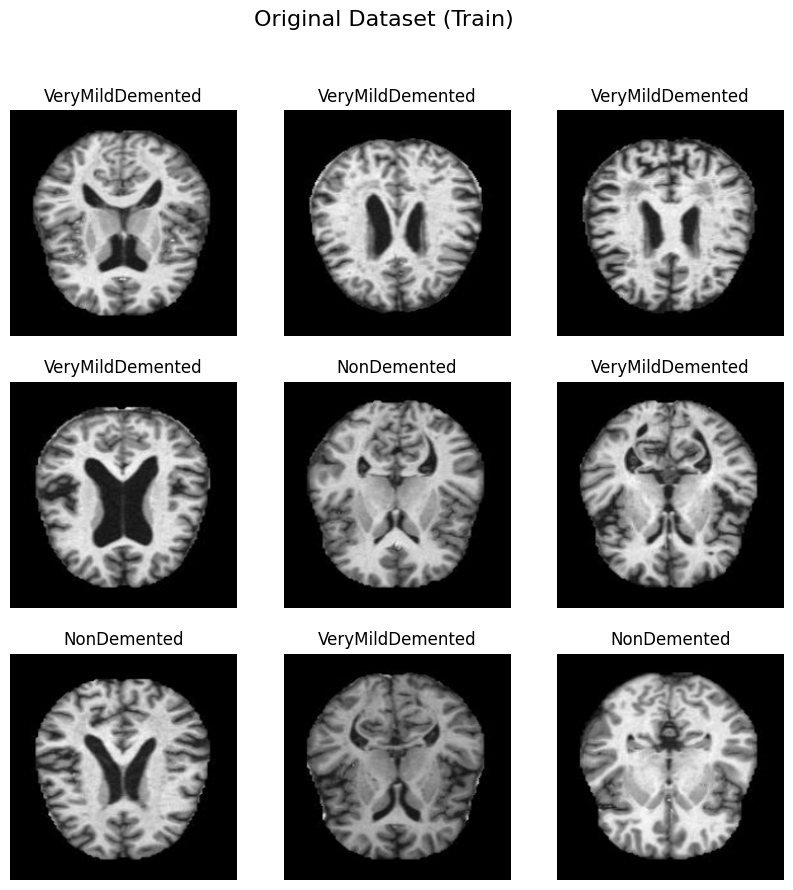

Sample images from Augmented Dataset (Train):


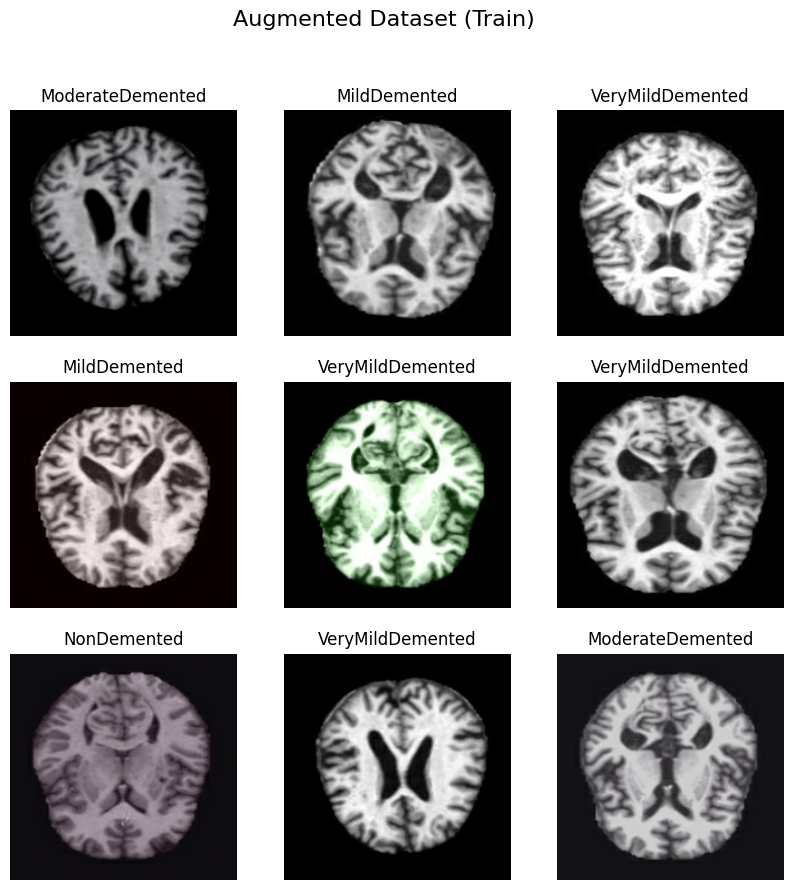

Sample images from Original Dataset (Validation):


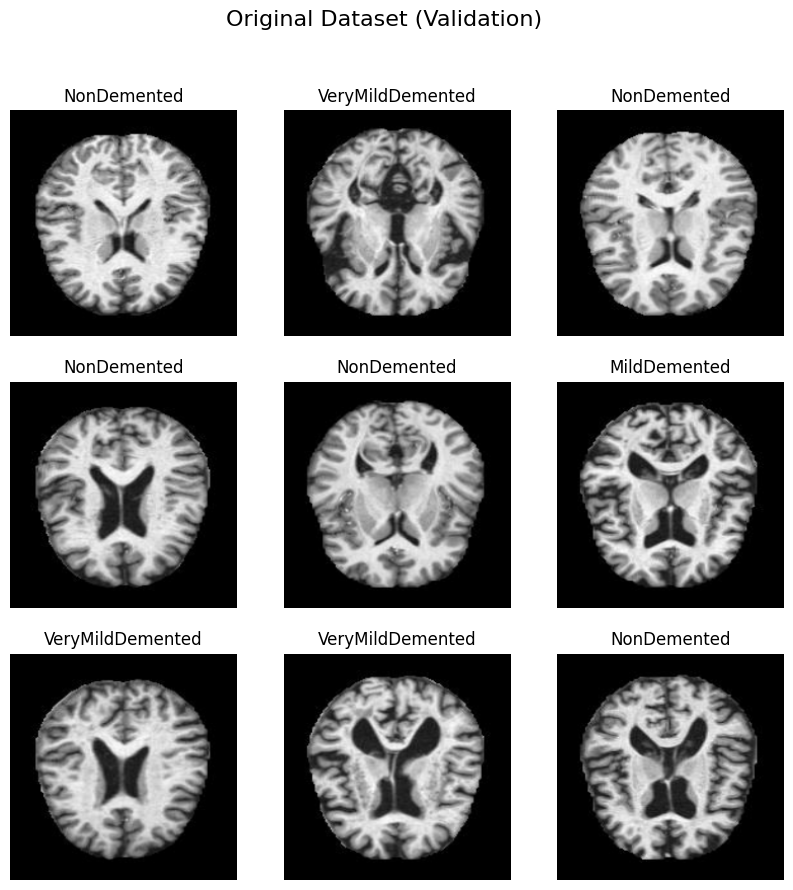

Sample images from Augmented Dataset (Validation):


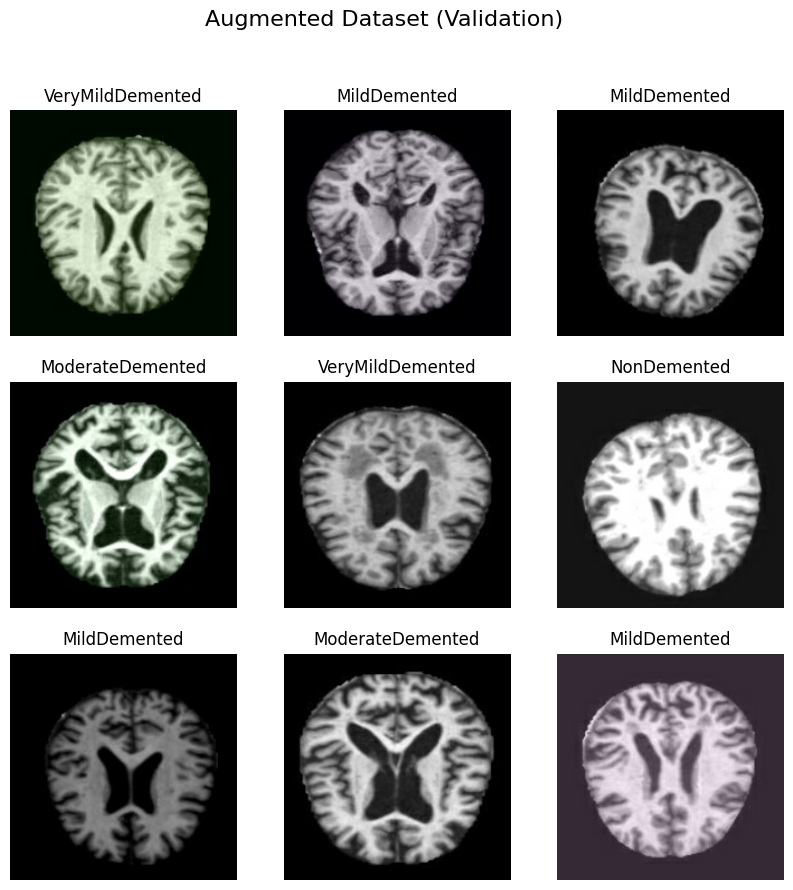

Sample images from Original Dataset (Testing):


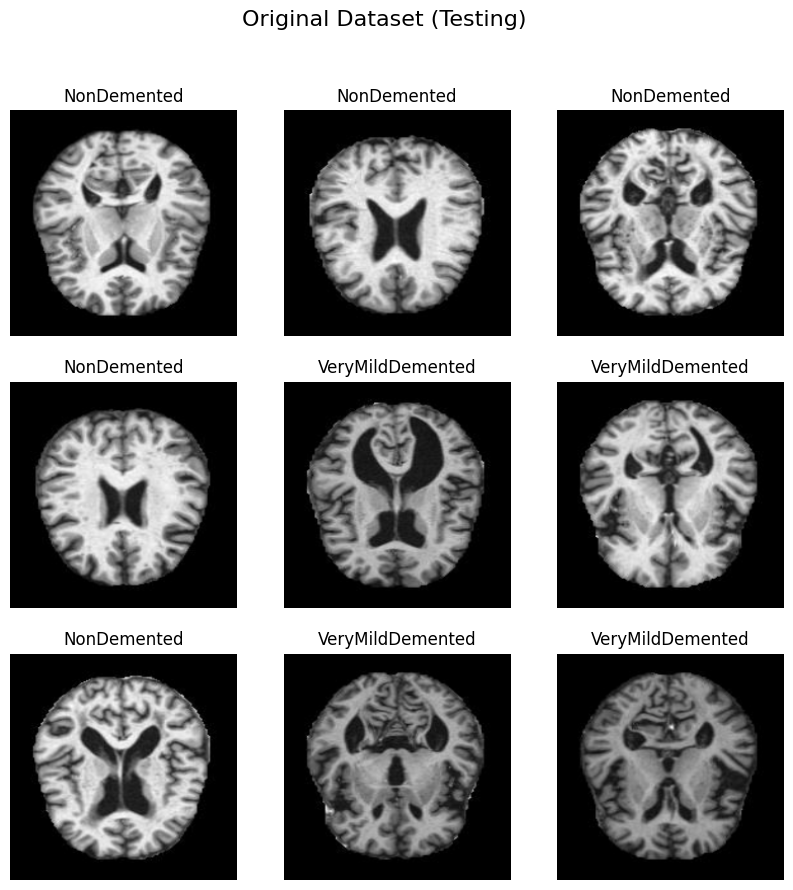

Sample images from Augmented Dataset (Testing):


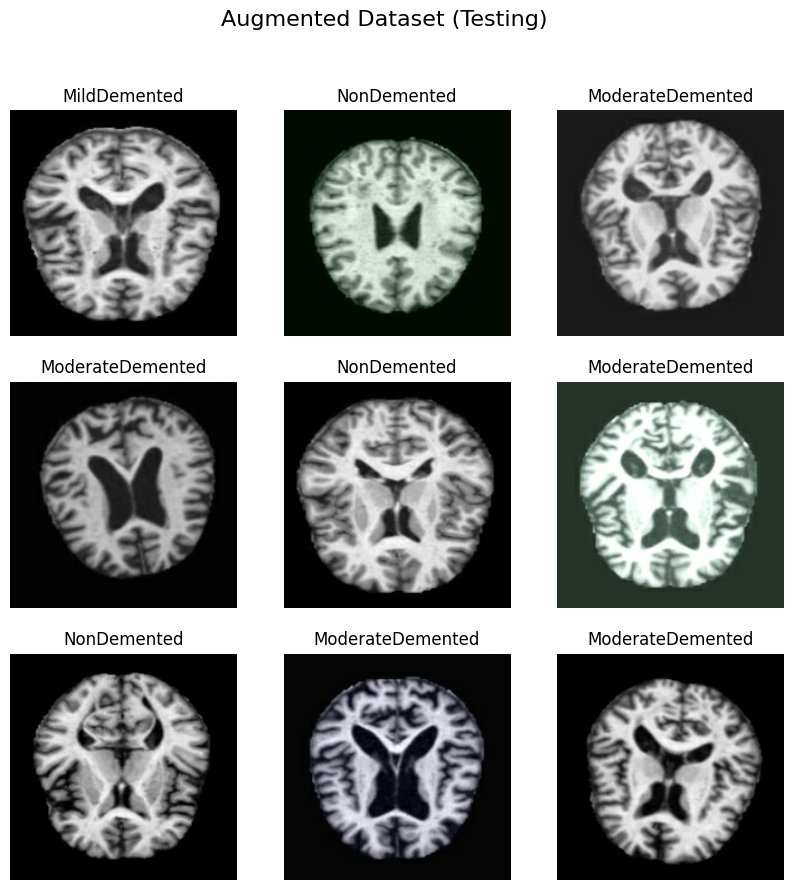

In [74]:
import matplotlib.pyplot as plt

# Function to display sample images from a dataset
def display_sample_images(dataset, class_names, num_images=9, title="Sample Images"):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())  # Convert Tensor to NumPy for display
        plt.title(class_names[label.numpy()])
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display some original dataset images (Train)
print("Sample images from Original Dataset (Train):")
display_sample_images(original_train, class_names_original, title="Original Dataset (Train)")

# Display some augmented dataset images (Train)
print("Sample images from Augmented Dataset (Train):")
display_sample_images(augmented_train, class_names_augmented, title="Augmented Dataset (Train)")

# Display validation images
print("Sample images from Original Dataset (Validation):")
display_sample_images(original_val, class_names_original, title="Original Dataset (Validation)")

print("Sample images from Augmented Dataset (Validation):")
display_sample_images(augmented_val, class_names_augmented, title="Augmented Dataset (Validation)")

# Display testing images
print("Sample images from Original Dataset (Testing):")
display_sample_images(original_test, class_names_original, title="Original Dataset (Testing)")

print("Sample images from Augmented Dataset (Testing):")
display_sample_images(augmented_test, class_names_augmented, title="Augmented Dataset (Testing)")


# Building MobileNet Model


In [77]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


# Define the MobileNet model
def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNet(
        input_shape=input_shape,
        include_top=False,  # Exclude the fully connected layer
        weights='imagenet'  # Use ImageNet pre-trained weights
    )

    # Unfreeze the base model
    base_model.trainable = True

    # Add custom classification layers
    from tensorflow.keras.regularizers import l2

    # Add L2 regularization to dense layers
    model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(1024, activation='relu'),  # Increased dense layer size
      BatchNormalization(),
      Dropout(0.4),  # Increased dropout
      Dense(512, activation='relu'),
      Dropout(0.3),
      Dense(256, activation='relu'),
      Dropout(0.2),
      Dense(4, activation='softmax')
    ])

    return model

# Dynamic rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

# Create and compile the model
model = create_mobilenet_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_15          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,939,716 (18.84 MB)

 Trainable params: 4,915,780 (18.75 MB)

 Non-trainable params: 23,936 (93.50 KB)

# Training the model

In [78]:
# Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.5400 - loss: 1.1114 - val_accuracy: 0.8468 - val_loss: 0.3728 - learning_rate: 1.0000e-04
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.8518 - loss: 0.3784 - val_accuracy: 0.9302 - val_loss: 0.1681 - learning_rate: 1.0000e-04
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9522 - loss: 0.1323 - val_accuracy: 0.9742 - val_loss: 0.0763 - learning_rate: 1.0000e-04
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9758 - loss: 0.0750 - val_accuracy: 0.9422 - val_loss: 0.1728 - learning_rate: 1.0000e-04
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9810 - loss: 0.0567 - val_accuracy: 0.9323 - val_loss: 0.1927 - learning_rate: 1.0000e-04
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9880 - loss: 0.0349 - val_accuracy: 0.9914 - val_loss: 0.0262 - learning_rate: 5.0000e-05
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/ste

# Visualizing Training **History**

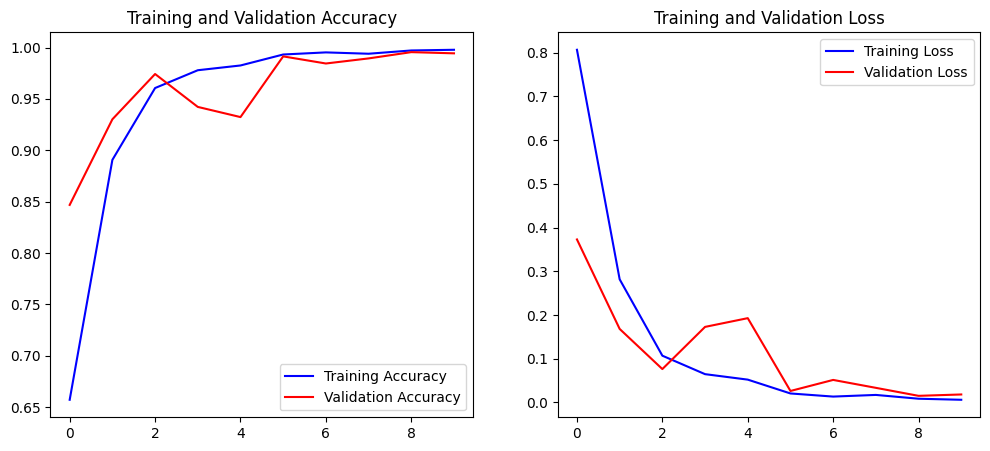

In [79]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

# Generate Predictions

Evaluating model on the test set:
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step


<Figure size 1000x800 with 0 Axes>

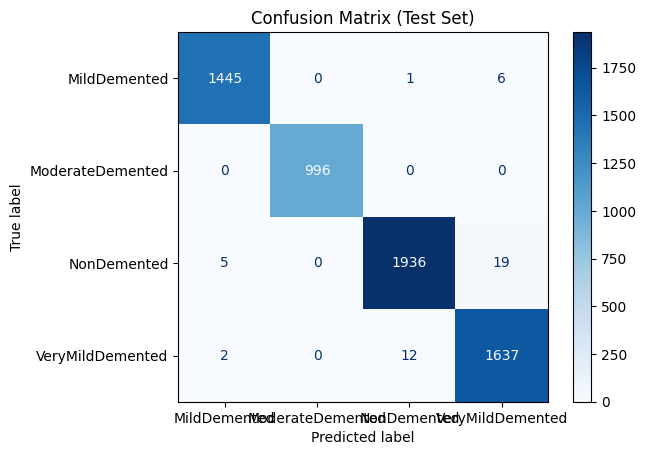

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      1452
ModerateDemented       1.00      1.00      1.00       996
     NonDemented       0.99      0.99      0.99      1960
VeryMildDemented       0.98      0.99      0.99      1651

        accuracy                           0.99      6059
       macro avg       0.99      0.99      0.99      6059
    weighted avg       0.99      0.99      0.99      6059



In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Generate predictions on the test dataset
def evaluate_model_on_test(model, test_dataset, class_names):
    # Unbatch the test dataset to get all individual images and labels
    test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # Generate predictions
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Confusion matrix
    cm = confusion_matrix(test_labels, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Print classification report
    report = classification_report(test_labels, predicted_classes, target_names=class_names)
    print("Classification Report:\n")
    print(report)

    return predicted_classes

# Call the function to evaluate and display results on the test set
print("Evaluating model on the test set:")
predicted_classes = evaluate_model_on_test(model, test_dataset, class_names_original)


# Plotting Confusion Matrix

<Figure size 1000x800 with 0 Axes>

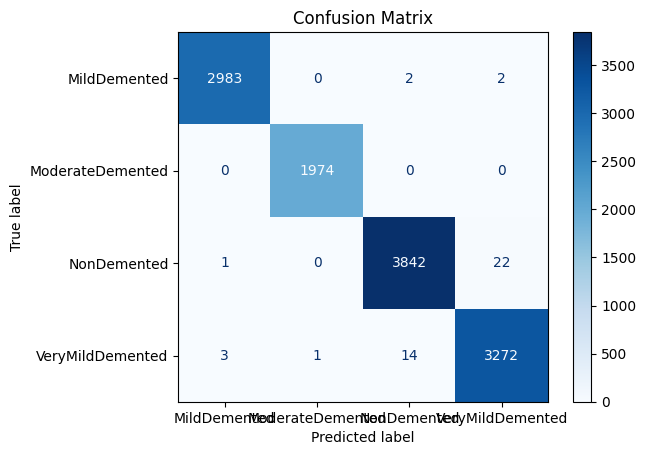

In [72]:
# Confusion matrix
cm = confusion_matrix(val_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()